In [61]:
# Runner script for InfoVAE

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

In [2]:
from data import train_x, test_x, valid_x

train_size = 60000
batch_size = 32
test_size = 10000
latent_dim = 2

# normalise data
train_x = train_x.map(lambda x: x / 255.)
test_x = test_x.map(lambda x: x / 255.)
valid_x = valid_x.map(lambda x: x / 255.)
# test_xn = np.array(list(test_x.as_numpy_iterator())) / 255.
# train_xn = np.array(list(train_x.as_numpy_iterator())) / 255.
train_dataset = train_x
test_dataset = test_x

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the f

In [3]:
from model import InfoVAE
model = InfoVAE(latent_dim)

In [4]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

In [5]:
from config import output_dir

def generate_and_save_images(model, epoch, random_vector_for_generation):
    predictions = model.decoder(random_vector_for_generation)
    fig = plt.figure(figsize=(4, 4))
    print("pred shape", predictions.shape)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
    plt.show()

In [6]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch

In [12]:
def print_ssim():
    first_batch = None
    for t in test_dataset:
        first_batch = t
        break
    latent_dist = tf.random.normal(shape=[32, latent_dim])
    reconstruction = model.decoder(latent_dist)
    ssim = tf.image.ssim(first_batch, reconstruction, max_val=1.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
    print(f"ssim: {ssim}")
    print(f"max: {tf.reduce_max(ssim, axis=None)}")

print_ssim()

ssim: [0.6881465  0.6915083  0.71292573 0.71370465 0.71121174 0.7157362
 0.718802   0.7135217  0.7176696  0.7141512  0.71150696 0.70938426
 0.6958172  0.7052948  0.70031214 0.69388175 0.69215137 0.68730646
 0.68205696 0.67632365 0.66913104 0.66110927 0.6537422  0.6965995
 0.6436213  0.6354652  0.699058   0.70568603 0.70205474 0.7057627
 0.71213204 0.70994383]
max: 0.7188019752502441


Epoch: 10, Test set Loss: 0.5549765825271606, Training set loss: 0.6210821866989136 time elapse for current epoch: 39.41478776931763
pred shape (16, 256, 256, 1)


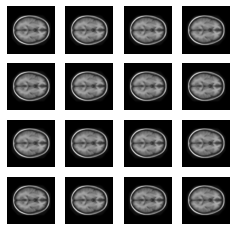

In [7]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    training_loss = -1
    for train_x in train_dataset:
        training_loss = model.train(train_x)
    end_time = time.time()

    test_loss = -1
    for t in test_dataset:
        test_loss = model.get_loss(t)
        break
    display.clear_output(wait=False)
    print('Epoch: {}, Test set Loss: {}, Training set loss: {} time elapse for current epoch: {}'
        .format(epoch, test_loss, training_loss, end_time - start_time))
    generate_and_save_images(model, epoch, random_vector_for_generation)